## Síntese de compensadores de avanço e atraso de fase pelo método do lugar das raízes



In [3]:
#!pip install matplotlib ipympl jupyter

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib widget

from scipy.signal import lsim
import sympy as sp
import numpy as np
import control as ct

s = ct.tf([1, 0], [1])

In [5]:
# Paleta de cores
cp = {
    'red': (1.0, 0.349, 0.369, 1.0),
    'green': (0.541, 0.788, 0.149, 1.0),
    'blue': (0.098, 0.510, 0.769, 1.0),
    'lred': (1.0, 0.588, 0.6, 1.0),
    'lgreen': (0.722, 0.894, 0.443, 1.0),
    'lblue': (0.369, 0.706, 0.918, 1.0),
    'orange': (1.0, 0.506, 0.227, 1.0),
    'yellow': (1.0, 0.792, 0.227, 1.0),
    'pink': (1.0, 0.349, 0.611, 1.0),
    'purple': (0.416, 0.298, 0.576, 1.0),
    'turquoise': (0.098, 0.761, 0.769, 1.0),
    'brown': (0.576, 0.380, 0.298, 1.0)
}

In [6]:
#Parâmetros:
Bb = 2.5 #Boca [m]
Db = 0.4 #Calado [m]
LOA = 8.4 #Comprimento fora-a-fora do barco [m]
Hb = 1.7 #Altura do barco [m]
Me = 10.0 #Massa do eixo do giroscópio [kg]
Md = 160.0 #Massa do disco do giroscópio [kg]
le = 0.5 #Comprimento do eixo do giroscópio [m]
re = 0.09 #Raio do eixo do giroscópio [m]
rd = 0.230 #Raio do disco do giroscópio [m]
ed = 0.150 #Espessura do disco do giroscópio [m]
g = 9.81 #Aceleração da gravidade [m/s²]
rho_w = 997.0 #Massa específica da água a 25°C [kg/m³]
wf_base = 1.40071 #freq. de exitação das ondas [rad/s]
A0_base = 2.0 #Altura das ondas [m]
Cg = 500.0 #Momento de restituição do giroscópio [N.m]
Bg = 250.0 #Coef. de dissipação por atrito do giroscópio [N.m.s]

c2 = 0.006 #Coef. adim. da dissipação por irradiação de ondas
c3 = 0.149 #Coef. adim. de massa adicional da embarcação

# Parâmetros da excitação
#am0 = 


Omega = sp.symbols('Ω') # Rotação própria do giroscópio

#Componentes da matriz A:
a_31 = - g*LOA*(Bb**2 - 6*Db**2)/(Db*((Bb**2)*(LOA+12*c3) + LOA*Hb**2))
a_33 = - 12*np.sqrt(2)*(g**2)*((Bb/g)**(3/2))*c2/((Bb**2)*(LOA+12*c3)+LOA*Hb**2)
a_34 = - 6*Omega*Md*(rd**2)/(Bb*Db*((Bb**2)*(LOA+12*c3)+LOA*Hb**2)*rho_w)
a_42 = -12*Cg/((ed**2)*(Md-Me)+3*Md*(rd**2)+Me*((le**2)+3*(re**2)))
a_43 = Omega*(-1 + (12*Md*rd**2)/((ed**2)*(Md-Me)+3*Md*rd**2 + Me*(le**2 + 3*re**2)))
a_44 = -12*Bg/((ed**2)*(Md-Me)+3*Md*rd**2 + Me*(le**2 + 3*re**2))

#Componentes da matriz B:
I_Gy = (1/12)*Me*(3*re**2 + le**2 - ed**2) + (1/12)*Md*(3*rd**2 + ed**2) #Momento de Inércia do Giroscópio em relação ao eixo y móvel

#Componentes da matriz E:
e_3 = g*LOA*(Bb**2 - 6*Db**2)/(Db*((Bb**2)*(LOA+12*c3)+LOA*Hb**2))

### Função de transferência do sistema:

In [7]:
#Matrizes


#Matriz A:
A = sp.Matrix([[0,0,1,0],[0,0,0,1],[a_31,0,a_33,a_34],[0,a_42,a_43,a_44]])

#Matriz B:
B = sp.Matrix([[0],[0],[0],[(1/I_Gy)]])

#Matriz E:
E = sp.Matrix([[0],[0],[e_3],[0]])

#Matriz C observando somente o ângulo de roll:
C_φ = sp.Matrix([[1, 0, 0, 0]])

#Matriz D:
D = sp.Matrix([[0]])

# =====================================================================

An = sp.lambdify((Omega), A)
Bn = sp.lambdify((),B)
Cn = sp.lambdify((),C_φ)
En = sp.lambdify((),E)

# =====================================================================

#Espaço de Estados com Ω = 8000 rpm:
mod_boat1 = ct.ss(An(8000*np.pi/30),B,C_φ,D)
mod_boat1

<LinearIOSystem:sys[4]:['u[0]']->['y[0]']>

In [8]:
L00 = ct.tf(mod_boat1)


# eliminando termos efetivamente nulos no numerador:
L_0 = ct.tf(-1*L00.num[0][0][2:], L00.den[0][0])

L_0

TransferFunction(array([ 1.84774660e-01, -8.64019967e-12]), array([1.00000000e+00, 9.52222040e+01, 1.10789883e+03, 1.18244144e+03,
       2.35942425e+03]))

### 1. Compensador de avanço de fase

Um *compensador de avanço de fase* tem uma função de transferência da forma:
$$ G_c(s) = \frac{1 + Ts}{1 + \alpha Ts} = \frac{1}{\alpha} \frac{s + \frac{1}{T}}{s + \frac{1}{\alpha T}} = \frac{1}{\alpha} \frac{s - z_c}{s - p_c}
\quad \text{com} \quad
0 < \alpha <1
$$

Tal compensador adiciona ao sistema um polo, em $\displaystyle s = p_c = -\frac{1}{\alpha T}$ e um zero em $\displaystyle s = z_c = -\frac{1}{T}$, com $p_c < z_c$.


#### 1.1. Síntese de um compensador de avanço de fase

Para a função de transferência do trabalho o sistema é do tipo 0 (sem polos na origem).



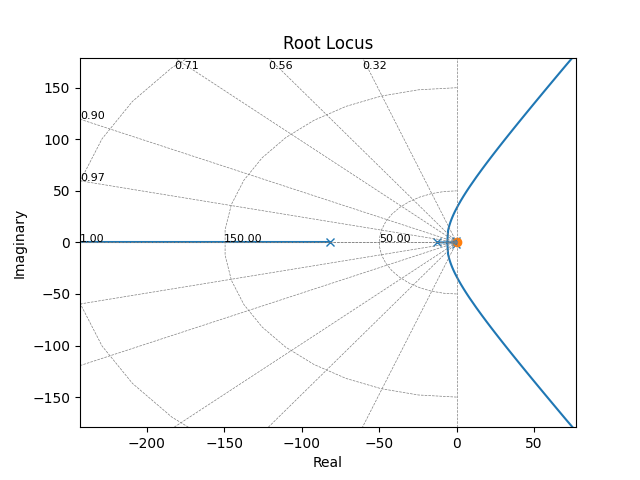

In [9]:
ct.root_locus(L_0)
plt.show()


In [10]:
ct.poles(L_0)

array([-81.8603462 +0.j        , -12.41365337+0.j        ,
        -0.47410221+1.44812641j,  -0.47410221-1.44812641j])

In [11]:
ct.zeros(L_0)

array([4.6760739e-11+0.j])

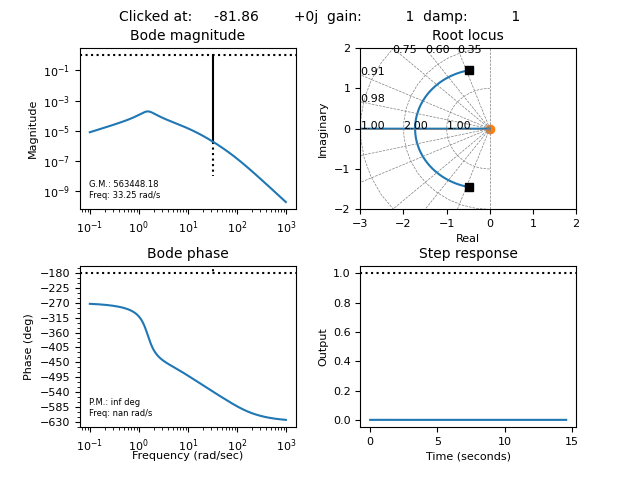

In [12]:
plt.ion()  # ativar o modo interativo
ct.sisotool(L_0, xlim_rlocus=(-3, 2), ylim_rlocus=(-2, 2),
            rlocus_grid=True)
plt.draw()  # desenhar a janela interativa

Vamos tentar projetar um compensador de avanço de fase que leve os polos dominantes do sistema em malha fechada para a posição $\bar p_{1,2} = -1.0 \pm 1 \ \mathsf{j}$ 

In [13]:
clp_1 = -1.0+1j
(np.abs(clp_1), -np.real(clp_1)/np.abs(clp_1)) # valores de (ω_n, ζ)

(1.4142135623730951, 0.7071067811865475)

Usando a função de transferência do sistema não compensado $\displaystyle L_0(s) = \frac{N(s)}{D(s)}$ verifica-se que, para o polo $\bar p_1$, o valor de $\phase{L_0(p_1)}$ é igual a:

In [14]:
φ_L_clp1 = np.angle(L_0(clp_1)) 
φ_L_clp1 * 180/np.pi  # exibe o resultado em graus

166.72560616727552

Ou seja, para que o polo desejado faça parte do lugar das raízes, é necessário um avanço de fase $\varphi$:

In [15]:
φ = np.pi - φ_L_clp1
φ * 180/np.pi   # exibe o resultado em graus

13.274393832724487

Uma regra prática para a alocação do zero $z_c$ e do polo $p_c$ do compensador que maximiza o valor de $\alpha$ (ou seja, maximiza o ganho em alta frequência) consiste em adotar:

\begin{align*}
& z_c = \text{Re}(\bar p_1) - \frac{\text{Im}(\bar p_1)}{\displaystyle \tan \left(\frac{\bar \psi_1 + \varphi}{2} \right)}
\\
& p_c = \text{Re}(\bar p_1) - \frac{\text{Im}(\bar p_1)}{\displaystyle \tan \left(\frac{\bar \psi_1 - \varphi}{2} \right)}
\end{align*}

com $\bar \psi_1= \phase{\bar p_1}$.

In [16]:
z_c = np.real(clp_1) - np.imag(clp_1)/np.tan(0.5 * (np.angle(clp_1) + φ))
z_c

-1.28415573511771

In [17]:
p_c = np.real(clp_1) - np.imag(clp_1)/np.tan(0.5 * (np.angle(clp_1) - φ))
p_c

-1.55744349793888

Assim, os valores de $T$ e $\alpha$ podem ser calculados como:
$$
T = - \frac{1}{z_c} \quad \text{e} \quad \alpha = \frac{z_c}{p_c}
$$

In [18]:
al = z_c/p_c
(- 1/z_c, al)

(0.77872174896944, 0.824527976017853)

A nova função de transferência de malha aberta, com o compensador de avanço projetado, é dada por:
$$
L_1(s) = K_c  \underbrace{\frac{1}{\alpha} \frac{(s - z_c)}{(s - p_c)}}_{\text{avanço}} \frac{N(s)}{D(s)}
$$

O ganho $K_c$ para que $\bar p_{1,2}$ sejam efetivamente polos em malha fechada pode então ser calculado a partir da condição $L_1(\bar p_1) = -1$, ou seja:

$$
\frac{K_c}{\alpha} \left| \frac{(\bar p_1-z_c)}{(\bar p_1-p_c)} \frac{N(\bar p_1)}{D(\bar p_1)} \right| = 1
\quad \Rightarrow \quad 
K_c = \alpha \left| \frac{(\bar p_1-p_c)}{(\bar p_1-z_c)} \frac{D(\bar p_1)}{N(\bar p_1)} \right|
$$

In [19]:
L_1_1 = 1/al * (s - z_c)/(s - p_c) * L_0
L_1_1

TransferFunction(array([ 2.24097503e-01,  2.87776093e-01, -1.34566228e-11]), array([1.00000000e+00, 9.67796475e+01, 1.25620203e+03, 2.90793127e+03,
       4.20100999e+03, 3.67466996e+03]))

In [20]:
L_1_1(clp_1)


(-0.00017952956236686049+7.926201654501281e-20j)

In [21]:
K_c = 1/np.abs(L_1_1(clp_1))
K_c

5570.1132828282925

Assim, temos o seguinte compensador de avanço:

In [22]:
G_lead = K_c/al * (s - z_c)/(s - p_c)
G_lead

TransferFunction(array([6755.51763535, 8675.13671512]), array([1.       , 1.5574435]))

Diagrama de Bode do compensador sintetizado:

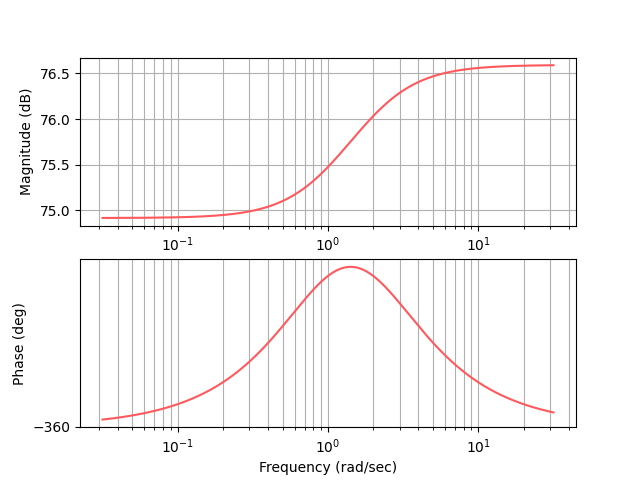

In [23]:
plt.figure()
G_lead_M, G_lead_φ, G_lead_ω = ct.bode_plot(G_lead,
                                   omega=np.logspace(-1.5, 1.5, 5001),
                                   color=cp['red'],
                                   dB=True)

Análise da função de transferência em malha aberta do sistema com compensador:

In [24]:
L_1 = G_lead * L_0
L_1

TransferFunction(array([ 1.24824848e+03,  1.60294544e+03, -7.49549134e-08]), array([1.00000000e+00, 9.67796475e+01, 1.25620203e+03, 2.90793127e+03,
       4.20100999e+03, 3.67466996e+03]))

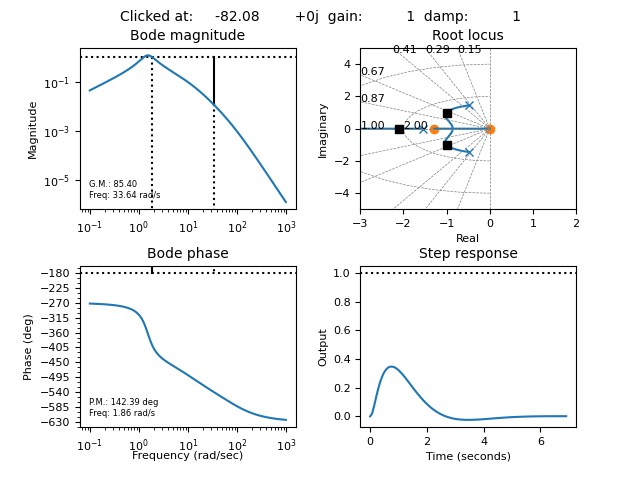

In [25]:
plt.ion()  # ativar o modo interativo
ct.sisotool(L_1, xlim_rlocus=(-3, 2), ylim_rlocus=(-5, 5),
             rlocus_grid=True)
plt.draw()  # desenhar a janela interativa

#### 1.2. Função de transferência entre referência (r) e saída (c)

In [ ]:
rc_tf_lead = ct.feedback(G_lead * L_0)
rc_tf_lead

TransferFunction(array([ 1.24824848e+03,  1.60294544e+03, -7.49549134e-08]), array([1.00000000e+00, 9.67796475e+01, 1.25620203e+03, 4.15617975e+03,
       5.80395544e+03, 3.67466996e+03]))

No such comm: 7adfecc1b9ef4ded9059ccfaddeac743


Frequencias naturais, fatores de amortecimento e zeros em malha fechada:

In [ ]:
ω_n_cl, ζ_cl, zeros_cl = rc_tf_lead.damp()
ω_n_cl

array([82.0818522 , 10.58261006,  2.11518521,  1.41421356,  1.41421356])

In [ ]:
ζ_cl

array([1.        , 1.        , 1.        , 0.70710678, 0.70710678])

In [ ]:
zeros_cl

array([-82.0818522 +0.j, -10.58261006+0.j,  -2.11518521+0.j,
        -1.        +1.j,  -1.        -1.j])

Diagrama de Bode da função de transferência do sistema em malha fechada:

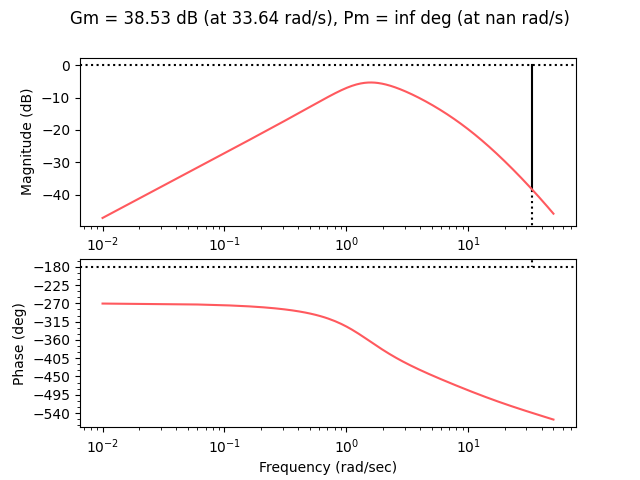

In [27]:
plt.figure()
rc_tf_M, rc_tf_φ, rc_tf_ω = ct.bode_plot(rc_tf_lead,
                                   omega=np.linspace(0.01, 50, 1001),
                                   color=cp['red'], margins = True,
                                   dB=True)

#### 1.3. Função de transferência entre referência (r) e entrada de controle (u)

In [28]:
ru_tf_lead = ct.feedback(G_lead, L_0)
ru_tf_lead

TransferFunction(array([6.75551764e+03, 6.51950415e+05, 8.31049571e+06, 1.75991778e+07,
       2.61969734e+07, 2.04683280e+07]), array([1.00000000e+00, 9.67796475e+01, 1.25620203e+03, 4.15617975e+03,
       5.80395544e+03, 3.67466996e+03]))

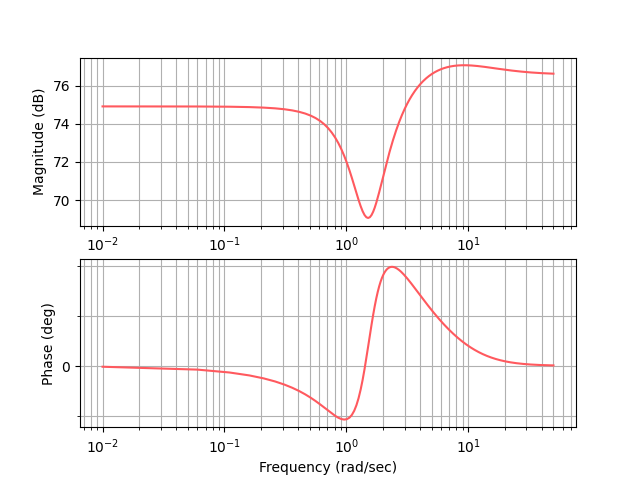

In [29]:
plt.figure()
ru_tf_M, ru_tf_φ, ru_tf_ω = ct.bode_plot(ru_tf_lead,
                                         omega=np.linspace(0.01, 50, 1001),
                                         color=cp['red'],
                                         dB=True)

#### 1.4. Resposta a degrau

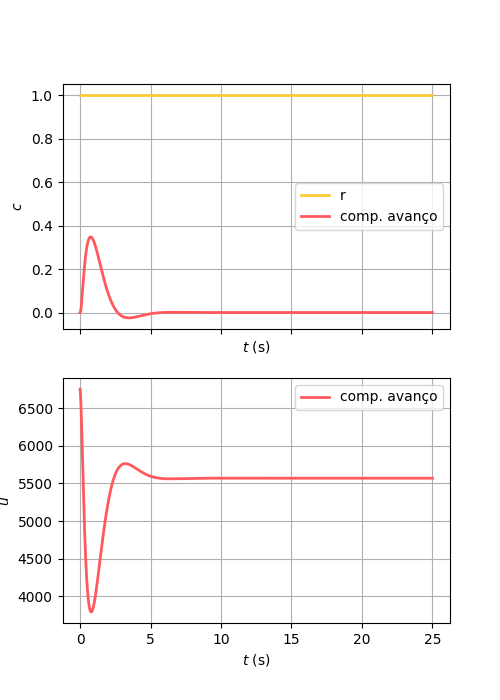

In [30]:
# simulação do sistema em MF
ts = np.linspace(0, 25, 1000)

t, y = ct.step_response(rc_tf_lead, ts)
t, u = ct.step_response(ru_tf_lead, ts)

fig, (state, control_input) = plt.subplots(
    2, 1, figsize=(5, 7), sharex=True)

state.plot(t, np.ones(len(t)), color=cp['yellow'], label='r', linewidth=2)
state.plot(t, y,
           color=cp['red'], label=r'comp. avanço', linewidth=2)
state.set_ylabel(r'$c$')
state.set_xlabel(r'$t$ (s)')
state.legend()
state.grid()

control_input.plot(t, u,
           color=cp['red'], label=r'comp. avanço', linewidth=2)
control_input.set_ylabel(r'$u$')
control_input.set_xlabel(r'$t$ (s)')
control_input.legend()
control_input.grid()

#### 1.5. Resposta a Impulso

c:\Users\Eduardo\anaconda3\envs\control_env\lib\site-packages\control\timeresp.py:1834: UserWarning: System has direct feedthrough: ``D != 0``. The infinite impulse at ``t=0`` does not appear in the output.
Results may be meaningless!
  warnings.warn("System has direct feedthrough: ``D != 0``. The "


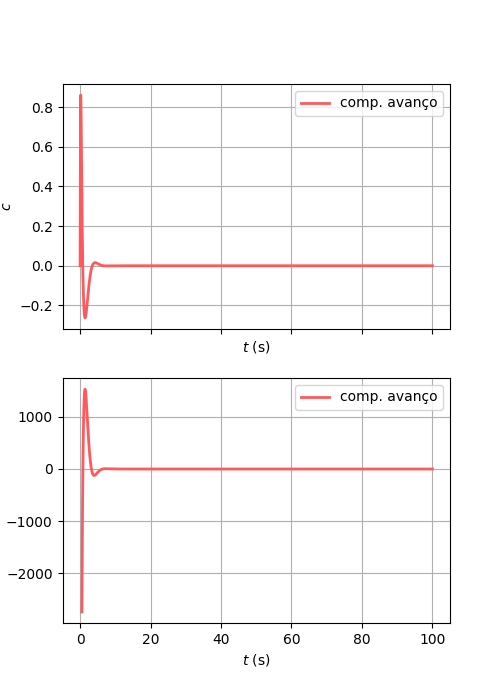

In [31]:
# simulação do sistema em MF
ts = np.linspace(0, 100, 2000)

t, y = ct.impulse_response(rc_tf_lead, ts)
t, u = ct.impulse_response(ru_tf_lead, ts)

fig, (state, control_input) = plt.subplots(
    2, 1, figsize=(5, 7), sharex=True)

#state.plot(t, t, color=cp['yellow'], label='r', linewidth=2)
state.plot(t, y, color=cp['red'], label='comp. avanço', linewidth=2)
state.set_ylabel(r'$c$')
state.set_xlabel(r'$t$ (s)')
state.legend()
state.grid()


control_input.plot(t[10:], u[10:], color=cp['red'],
                   label='comp. avanço', linewidth=2)
control_input.set_ylabel(r'$u$')
control_input.set_xlabel(r'$t$ (s)')
control_input.legend()
control_input.grid()

### 2. Compensador de atraso de fase

Um *compensador de atraso de fase* tem uma função de transferência da forma:
$$ G_g(s) = \frac{1 + Ts}{1 + \beta Ts} = \frac{1}{\beta} \frac{s + \frac{1}{T}}{s + \frac{1}{\alpha T}} = \frac{1}{\beta} \frac{s - z_g}{s - p_g}
\quad \text{com} \quad
\beta >1
$$

Tal compensador adiciona ao sistema um polo, em $\displaystyle s = p_g = -\frac{1}{\beta T}$ e um zero em $\displaystyle s = z_g = -\frac{1}{T}$, com $z_g < p_g$, sem alterar o valor de $\displaystyle K_m = \lim_{s \to 0} s^m L(s)$ do sistema.

Observando sua *resposta em frequência*, nota-se que o *atraso de fase* ocorre em todo o espectro de frequência. Em termos de *ganho*, este tipo de compensador tem características de um filtro *passa-baixas*: 
* não há praticamente nenhuma redução no ganho para $\displaystyle \omega T \ll \frac{1}{\beta}$;
* o ganho é atenuado em $\displaystyle -20 \ |\log_{10} \beta| \ \text{dB}$ para $\omega T \gg 1$.

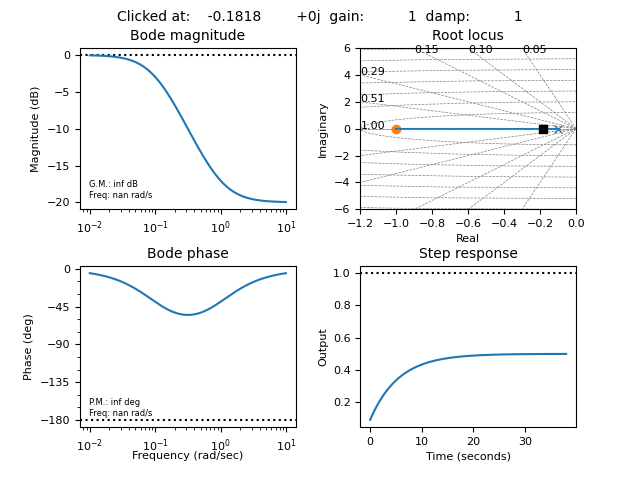

In [32]:
plt.ion()  # ativar o modo interativo
ct.sisotool((1+s)/(1 + 10*s), xlim_rlocus=(-1.2, 0), ylim_rlocus=(-6, 6),
            rlocus_grid=True, dB=True)
plt.draw()  # desenhar a janela interativa

O atraso de fase em si não é um efeito desejável (veremos adiante que *atrasos podem ser prejudiciais à estabilidade* do sistema em malha fechada). 

No entanto, a presença deste tipo de compensador torna possível aumentar o ganho $K_m$ do sistema (*reduzindo erros de acompanhamento de referência*) sem afetar de forma significativa a resposta do sistema em alta frequência. 

A configuração tipicamente escolhida para o *compensador de atraso* é um *dipolo*, ou seja, escolhem-se $z_g$ e $p_g$ com $\displaystyle \frac{z_g}{p_g} = \beta$ tais que, sendo $\bar p$ um *polo dominante* do sistema em malha fechada:
$$
\left| \bar p - z_g \right| \approx \left| \bar p - p_g \right|
\quad \Rightarrow \quad 
|G_c(\bar p)| \approx \frac{1}{\beta}
$$

Desta forma, ao inserirmos na malha de controle um compensador de atraso, podemos amplificar $K_m$ em $\beta$ vezes, reduzindo erros de acompanhamento de referência e mantendo praticamente inalterada a resposta do sistema em alta frequência. 

#### 2.1. Síntese de um compensador de atraso

Voltando ao exemplo anterior, vamos avaliar como reduzir em 10 vezes o erro de acompanhamento do sistema. 

Partimos da função de transferência em malha aberta já com o compensador de avanço:
$$
L_1 (s) = K_c \underbrace{\frac{1}{\alpha} \frac{(s - z_c)}{(s - p_c)}}_{\text{avanço}} \frac{N(s)}{D(s)}
$$
e a modificamos para a forma:
$$
L_2 (s) = \overbrace{\beta K_c}^{\text{ganho}} \underbrace{\frac{1}{\beta} \frac{(s - z_g)}{(s - p_g)}}_{\text{atraso}} \underbrace{\frac{1}{\alpha} \frac{(s - z_c)}{(s - p_c)}}_{\text{avanço}} \frac{N(s)}{D(s)}
$$

Considere as posições dos polos dominantes em malha fechada:

(array([-82.0818522 +0.j, -10.58261006+0.j,  -2.11518521+0.j,
         -1.        +1.j,  -1.        -1.j]),
 array([-1.28415574e+00+0.j,  4.67607390e-11+0.j]))

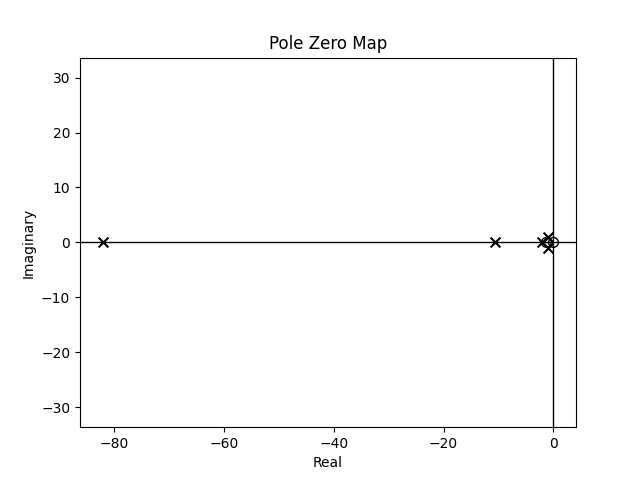

In [33]:
plt.figure()
ct.pzmap(rc_tf_lead)

Assim, escolhemos o *dipolo* com:

In [34]:
z_g = -0.1
p_g = -0.01
β = z_g/p_g
β

10.0

E obtemos a nova função de transferência em malha aberta:

In [35]:
L_2 = L_1 * (s - z_g)/(s - p_g)
L_2

TransferFunction(array([ 1.24824848e+03,  1.72777029e+03,  1.60294544e+02, -7.49549134e-09]), array([1.00000000e+00, 9.67896475e+01, 1.25716983e+03, 2.92049329e+03,
       4.23008931e+03, 3.71668006e+03, 3.67466996e+01]))

Para a qual obtemos o novo valor de $K_1$ para $L_2$ ($\beta = 10$ vezes superior ao obtido para $L_1$):

In [36]:
K1_2 = L_2.num[0][0][-1]/L_2.den[0][0][-2]
K1_2

-2.0167168563860857e-12

Lugar das raízes da função de transferência $L_2(s)$:

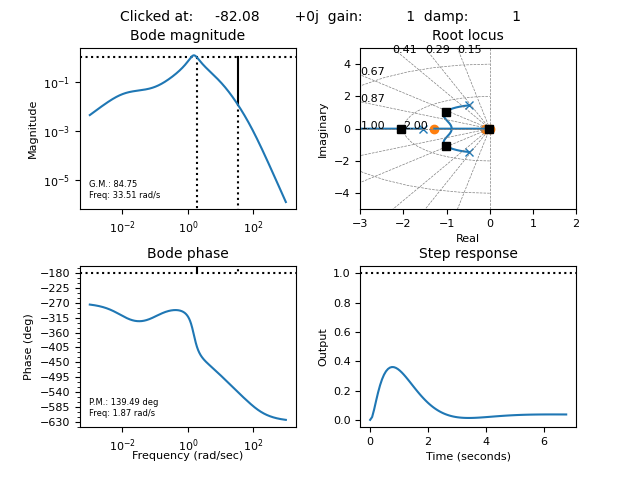

In [37]:
plt.ion()  # ativar o modo interativo
ct.sisotool(L_2, xlim_rlocus=(-3, 2), ylim_rlocus=(-5, 5),
            rlocus_grid=True)
plt.draw()  # desenhar a janela interativa

O compensador completo pode ser descrito como:

In [38]:
G_ll = G_lead * (s - z_g)/(s - p_g)
G_ll

TransferFunction(array([6755.51763535, 9350.68847866,  867.51367151]), array([1.        , 1.5674435 , 0.01557443]))

Diagrama de Bode do compensador completo:

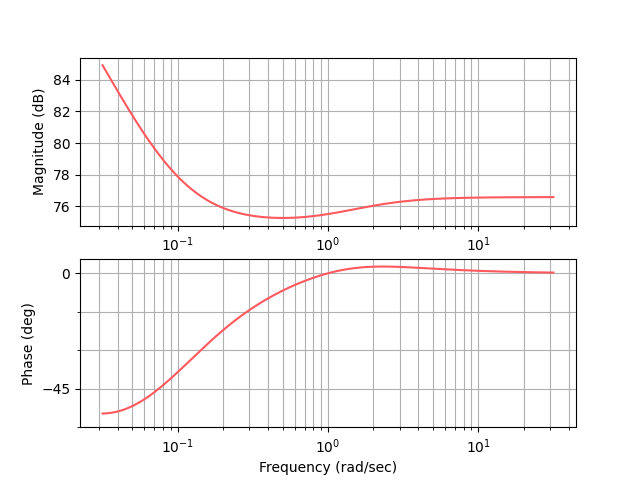

In [39]:
plt.figure()
G_ll_M, G_ll_φ, G_ll_ω = ct.bode_plot(G_ll,
                                      omega=np.logspace(-1.5, 1.5, 5001),
                                      color=cp['red'],
                                      dB=True)

#### 2.2. Função de transferência entre referência (r) e saída (c)

In [40]:
rc_tf_ll = ct.feedback(G_ll * L_0)
rc_tf_ll

TransferFunction(array([ 1.24824848e+03,  1.72777029e+03,  1.60294544e+02, -7.49549134e-09]), array([1.00000000e+00, 9.67896475e+01, 1.25716983e+03, 4.16874177e+03,
       5.95785960e+03, 3.87697461e+03, 3.67466996e+01]))

Frequencias naturais, fatores de amortecimento e zeros em malha fechada:

In [41]:
ω_n_cl, ζ_cl, zeros_cl = rc_tf_ll.damp()
ω_n_cl

array([8.20816107e+01, 1.06011457e+01, 2.05484155e+00, 1.46165846e+00,
       1.46165846e+00, 9.61943400e-03])

In [42]:
ζ_cl

array([1.        , 1.        , 1.        , 0.69866872, 0.69866872,
       1.        ])

In [43]:
zeros_cl

array([-8.20816107e+01+0.j        , -1.06011457e+01+0.j        ,
       -2.05484155e+00+0.j        , -1.02121504e+00+1.04573672j,
       -1.02121504e+00-1.04573672j, -9.61943400e-03+0.j        ])

Diagrama de Bode da função de transferência do sistema em malha fechada:

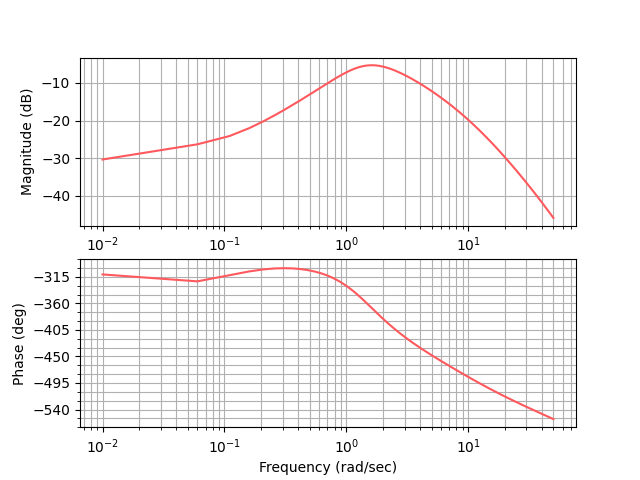

In [44]:
plt.figure()
rc_tf_M, rc_tf_φ, rc_tf_ω = ct.bode_plot(rc_tf_ll,
                                   omega=np.linspace(0.01, 50, 1001),
                                   color=cp['red'],
                                   dB=True)

#### 2.3. Função de transferência entre referência (r) e entrada de controle (u)

In [45]:
ru_tf_ll = ct.feedback(G_ll, L_0)
ru_tf_ll

TransferFunction(array([6.75551764e+03, 6.52625967e+05, 8.37569075e+06, 1.84302274e+07,
       2.79568911e+07, 2.30880253e+07, 2.04683280e+06]), array([1.00000000e+00, 9.67896475e+01, 1.25716983e+03, 4.16874177e+03,
       5.95785960e+03, 3.87697461e+03, 3.67466996e+01]))

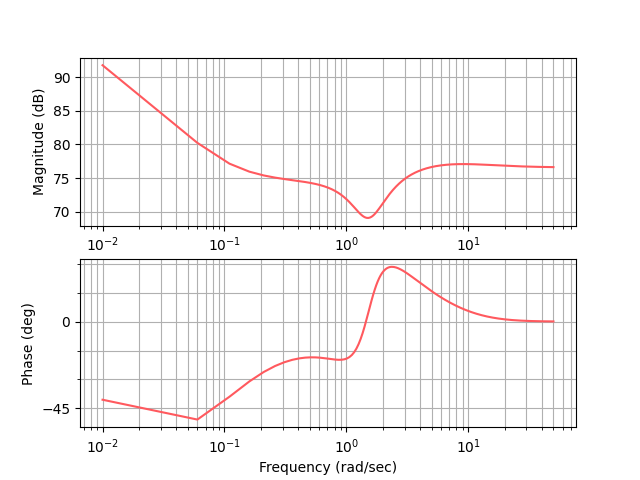

In [46]:
plt.figure()
ru_tf_M, ru_tf_φ, ru_tf_ω = ct.bode_plot(ru_tf_ll,
                                         omega=np.linspace(0.01, 50, 1001),
                                         color=cp['red'],
                                         dB=True)

#### 2.4. Resposta a degrau

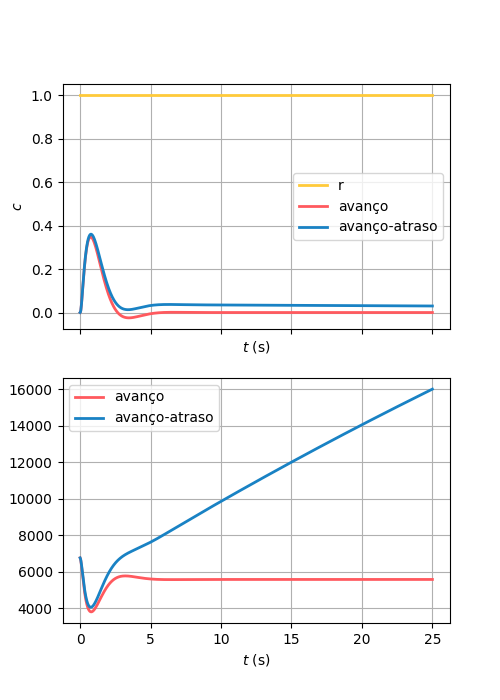

In [47]:
# simulação do sistema em MF
ts = np.linspace(0, 25, 1000)

t, y_l = ct.step_response(rc_tf_lead, ts)
t, u_l = ct.step_response(ru_tf_lead, ts)

t, y_ll = ct.step_response(rc_tf_ll, ts)
t, u_ll = ct.step_response(ru_tf_ll, ts)

fig, (state, control_input) = plt.subplots(
    2, 1, figsize=(5, 7), sharex=True)

state.plot(t, np.ones(len(t)), color=cp['yellow'], label='r', linewidth=2)
state.plot(t, y_l,
           color=cp['red'], label=r'avanço', linewidth=2)
state.plot(t, y_ll,
           color=cp['blue'], label=r'avanço-atraso', linewidth=2)
state.set_ylabel(r'$c$')
state.set_xlabel(r'$t$ (s)')
state.legend()
state.grid()

control_input.plot(t, u_l,
           color=cp['red'], label=r'avanço', linewidth=2)
control_input.plot(t, u_ll,
                   color=cp['blue'], label=r'avanço-atraso', linewidth=2)
control_input.set_ylabel(r'$u$')
control_input.set_xlabel(r'$t$ (s)')
control_input.legend()
control_input.grid()